![header](../header.png)

# Guia de Processamento Digital de Imagens em linguagem de programação Python

## Estudo de caso em Reconhecimento Automático de Placas Veiculares

### Descrição

Esse guia é composto de diversos notebooks que têm por principal objetivo apresentar o desenvolvimento de algoritmos em linguagem python com uso da biblioteca de visão computacional OpenCV. Para isso, toma como exemplo um estudo de caso em reconhecimento automático de placas veiculares. As imagens utilizadas são do [SSIG-ALPR Database](http://www.smartsenselab.dcc.ufmg.br/ssig-alpr-database).

### Notebook número 7

Esse notebook tem por objetivo exemplificar a **segmentação baseada em descontinuidades** por meio do uso da **Transformada de Hough** para detecção de linhas na imagem. 

Nesse caso, o primeiro passo a ser dado é a importação das bibliotecas, a definição das funções úteis e a leitura das imagens.

In [2]:
import numpy as np
import cv2
from os import listdir, path
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Funcoes uteis 

# Funcao de leitura de imagens
def pdiguide_imgRead(path,convert=True,show=False):
    # Essa funcao cria uma lista de imagens dado o caminho (path) de um diretório.
    # Se "convert" é Verdadeiro, a função irá realizar a conversão das imagens de RGB para Grayscale
    # Se "show" é Verdadeiro, a função irá exibir as imagens carregadas
    
    img = [] # lista de imagens em tons de cinza

    number_of_files = len(listdir(path))#a função listdir forma uma lista com todos os arquivos

    if(show):
        plt.figure(figsize=[20,10]) #define a existencia de uma figura e define o seu tamanho

    #A cada iteração uma imagem é carregada e convertida para tons de cinza, 
    #ao passo que é armazenada nos vetores acima
    for i in range(0,number_of_files): 
        img.append(cv2.imread(path + str(i+1) + '.png'))
        if(convert):
            img[i]=(cv2.cvtColor(img[i],cv2.COLOR_RGB2GRAY))

        #Exibe as imagens
        if(show):
            plt.subplot(1+number_of_files/5,5,i+1)
            plt.imshow(img[i],cmap='gray'),plt.xticks([]),plt.yticks([]) 
            #xticks e yticks controlam as escalas exibidas, nesse caso, serão nulas.
            
    print("Leitura finalizada, total de imagens lidas = ",len(img))
    return img #retorna a lista de imagens
    
# Funcao apenas para exibicao da lista de imagens
def pdiguide_show(list_of_imgs):
    # Essa funcao exibe as imagens dado uma lista de imagens.
    number_of_files = len(list_of_imgs)
    plt.figure(figsize=[20,10]) 
    for i in range(0,number_of_files): 
        plt.subplot(1+number_of_files/5,5,i+1)
        plt.imshow(img[i],cmap='gray'),plt.xticks([]),plt.yticks([]) 
        
# Funcao para calcular e exibir o histograma de uma imagem 
def pdiguide_histogram(img,nbins,show=False):
    # Essa funcao calcula o histograma de um vetor 2D (imagem grayscale)
    # com valores inteiros entre 0-255.
    # Essa imagem retorna um vetor 1D com o histograma e os pontos 
    # que representam o bin_edges para plotagem do histograma.
    # Caso show seja verdadeiro ela mesmo irá plotar o histograma
    h, bin_edges = np.histogram(img.ravel(), nbins,(0,255))
    if show:
        w=256./nbins
        bin_centers = bin_edges[1:]-(w/2)
        plt.bar(bin_centers, h, width=w)
    
    return h, bin_edges

In [4]:
# Leitura das imagens
path = '../Data/'
img = pdiguide_imgRead(path)

Leitura finalizada, total de imagens lidas =  20


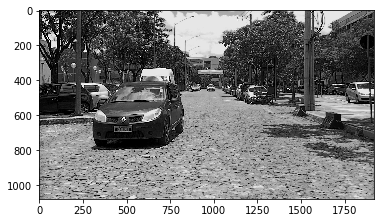

In [5]:
# Utilizando somente a imagem 0 
im = img[8]
plt.imshow(im,cmap='gray')

### Segmentação de Imagens por Descontinuidade - Transformada de Hough

Alguns algoritmos buscam detectar os objetos de uma imagem tomando como característica uma descontinuidade. Os tipos mais simples de descontinuidade são pontos, segmentos de reta, junções e as bordas (PEDRINI;SCHWARTZ,2008). Para exemplificar iremos trabalhar com a Transformada de Hough.

#### Transformada de Hough

A Transformada de Hough (TH) é uma técnica de reconhecimento de formas
geométricas facilmente parametrizadas como linhas, círculos e elipses. Pontos colineares ou
pontos de uma determinada forma geométrica no plano da imagem podem ser mapeados
em construções geométricas que se intercedem no espaço da transformada ou espaço de
parâmetros (HART, 2009).

A TH para retas de Duda e Hart (1971) utiliza a equação normal da reta (equação abaixo) para parametrizar os pontos do plano
da imagem ($x_{i}, y_{i}$). Dessa forma, uma reta é especificada pelo ângulo da normal ($\theta$) e a distância
algébrica a origem ($\rho$).

$$\rho = x_{i}cos(\theta) + y_{i}sen(\theta)$$ 

Esses parâmetros podem ser limitados de modo a garantir que cada reta no espaço
da imagem possua um único ponto (ρ, θ) que a represente no espaço de parâmetros. Assim,
essa transformada mapeia pontos colineares em curvas senoidais que se interceptam em
um único ponto no espaço de parâmetros (HART, 2009). Em resumo:

- um ponto no plano da imagem corresponde a uma curva senoidal no plano dos parâmetros;
- um ponto no plano dos parâmetros corresponde a uma reta no plano da imagem;
- pontos sobre uma mesma reta no plano da imagem correspondem a curvas sobre um ponto comum no plano dos parâmetros;
- pontos sobre uma mesma curva no plano dos parâmetros correspondem a diferentes linhas sobre um único ponto no plano da imagem.

Duda e Hart (1971) ainda propuseram o uso do método para uso na detecção
de outros padrões geométricos a partir de curvas de parametrização analíticas, como a
detecção de círculos. Entretanto neste notebook utilizou-se apenas a TH como detector de
linhas.

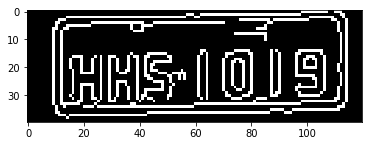

In [8]:
im_cut = im[660:700,420:540]

low_threshod = 120
alpha = 2
kernel_size = 3
edges = cv2.Canny(im_cut,low_threshod,alpha*low_threshod,kernel_size,L2gradient=True)

plt.imshow(edges,cmap='gray')

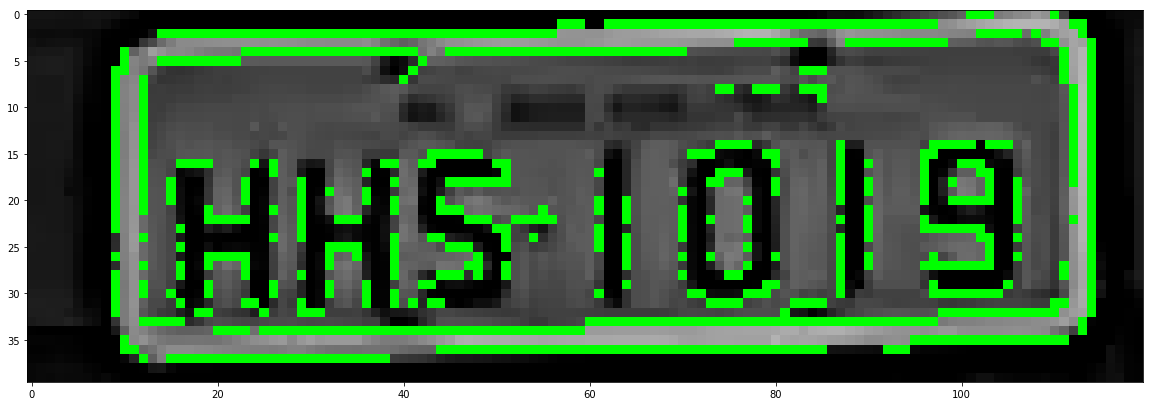

In [21]:
rho_resolution = 1
theta_resolution = np.pi/180
HT_threshold = 10
minLinLength = 5
maxLineGap = 0
lines = cv2.HoughLinesP(edges,rho_resolution,theta_resolution,HT_threshold,minLinLength,maxLineGap)

img_color = cv2.cvtColor(im_cut,cv2.COLOR_GRAY2BGR)
for i in range(lines.shape[0]):
    for x1,y1,x2,y2 in lines[i]:
        cv2.line(img_color,(x1,y1),(x2,y2),(0,255,0),1)
plt.figure(figsize = (20,10))
plt.imshow(img_color,cmap='gray')